In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.animation as animation

from torch.utils.data import Dataset
# import binvox
import os
import json
import trimesh
import skimage
import random
# from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, scale_to_unit_sphere
import mesh_to_sdf
import pyrender
import numpy as np
import matplotlib.pyplot as plt
import io
from deep_sdf import utils, metrics, plotting
import math
import pandas as pd
import pytorch3d
import torch
import matplotlib

import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'pytorch3d'

In [8]:
i/n

0.1

In [2]:

folder = "/mnt/hdd/ShapeNetCore.v2/02691156" # planes
folder = "/mnt/hdd/ShapeNetCore.v2/04256520"    # sofas
# folder = "/mnt/hdd/ShapeNetCore.v2/03636649"    # lamps



i = 0
n = 0
for fold in os.listdir(folder):
    p = os.path.join(folder, fold, "models/model_normalized.obj")
    mesh = trimesh.load(p)
    n += 1
    try:
        ret = mesh_to_sdf.mesh_to_voxels(mesh, voxel_resolution=128, check_result=True, pad=True, sign_method="depth")
        print("Success", p)
        i += 1
    except mesh_to_sdf.BadMeshException:
        pass
        # print("BadMeshException")

print("Total", i, " out of ", len(os.listdir(folder)))

# idxs_neg = np.argwhere(sdf < 1).reshape(-1)
# # idxs_neg = np.argwhere((-0.1 < sdf) & (sdf < 0.0)).reshape(-1)

# print(len(idxs_neg))

# anim = plotting.render_sdf_vid(points[idxs_neg], sdf[idxs_neg])
# plt.close()

# from IPython.display import HTML
# HTML(anim.to_jshtml())

KeyboardInterrupt: 

In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

# df = pd.read_csv("examples/planes/Evaluation/2000/chamfer.csv", delimiter=";")
# df_line = pd.read_csv("../../shared/deepsdfcomp/searches/double_nonlinearity/line/Evaluation/2000/chamfer.csv", delimiter=";")
# df_plane = pd.read_csv("../../shared/deepsdfcomp/searches/double_nonlinearity/plane/Evaluation/2000/chamfer.csv", delimiter=";")
df_baseline = pd.read_csv("../../shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", delimiter=";")
df_siren = pd.read_csv("../../shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer.csv", delimiter=";")
df_siren_128 = pd.read_csv("../../shared/deepsdfcomp/searches/double_nonlinearity/siren_width=128_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";")
df_siren_64 = pd.read_csv("../../shared/deepsdfcomp/searches/double_nonlinearity/siren_width=64_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";")
df_siren_256 = pd.read_csv("../../shared/deepsdfcomp/searches/double_nonlinearity/siren_width=256_no_bottleneck_v2/Evaluation/2000/chamfer.csv", delimiter=";")
df_voxelized = pd.read_csv("data/voxelize_until_cd_meshes_CD=0.001/run_voxelize_until_CD_logs.csv")

# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# titles = ["NL Combination: Line", "SIREN", "Baseline"]
# for i, df in enumerate([df1, df2, df_baseline]):
#     df.head()
#     print(df.mean())
#     print(df.median())
#     df.hist("chamfer_dist", bins=100, ax=ax[i])
#     ax[i].set_xlim((0, 0.010))
#     # ax[i].set_ylim((0, 350))
#     ax[i].set_title(titles[i])

In [4]:
df_siren["chamfer_dist"].mean()

0.00017863627278979764

In [19]:
print("baseline: ", df_baseline.mean(numeric_only=True), df_baseline.median(numeric_only=True), "\n")
print("siren: ", df_siren.mean(numeric_only=True), df_siren.median(numeric_only=True), "\n")
print("siren 256: ", df_siren_256.mean(numeric_only=True), df_siren_256.median(numeric_only=True), "\n")
# print("siren 128: ", df_siren_128.mean(numeric_only=True), df_siren_128.median(numeric_only=True), "\n")
print("siren 64: ", df_siren_64.mean(numeric_only=True), df_siren_64.median(numeric_only=True), "\n")

baseline:  chamfer_dist          0.000147
normal_consistency    0.020689
dtype: float64 chamfer_dist          0.000040
normal_consistency    0.021629
dtype: float64 

siren:  chamfer_dist          0.000179
normal_consistency    0.019108
dtype: float64 chamfer_dist          0.000032
normal_consistency    0.019626
dtype: float64 

siren 256:  chamfer_dist          0.000225
normal_consistency    0.020490
dtype: float64 chamfer_dist          0.000037
normal_consistency    0.020707
dtype: float64 

siren 64:  chamfer_dist          0.000296
normal_consistency    0.016108
dtype: float64 chamfer_dist          0.000072
normal_consistency    0.017378
dtype: float64 



In [37]:
pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=128_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";").mean(), pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=128_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";").median()

/tmp/ipykernel_77725/218010727.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=128_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";").mean(), pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=128_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";").median()
/tmp/ipykernel_77725/218010727.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=128_no_bottlene

(chamfer_dist          0.000225
 normal_consistency    0.018310
 dtype: float64,
 chamfer_dist          0.000039
 normal_consistency    0.018907
 dtype: float64)

In [41]:
pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=256_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";").mean(), pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=256_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";").median()

/tmp/ipykernel_77725/3910078897.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=256_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";").mean(), pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=256_no_bottleneck/Evaluation/2000/chamfer.csv", delimiter=";").median()
/tmp/ipykernel_77725/3910078897.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.read_csv("../../shared/deepsdfcomp/size_vs_performance/siren_width=256_no_bottle

(chamfer_dist          0.000225
 normal_consistency    0.020490
 dtype: float64,
 chamfer_dist          0.000037
 normal_consistency    0.020707
 dtype: float64)

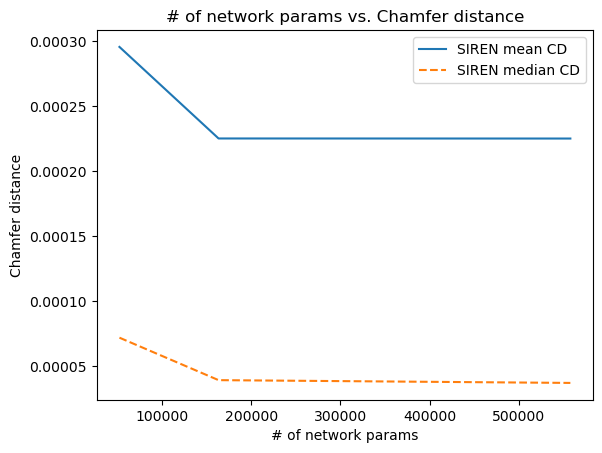

In [40]:
exps = [
    "../../shared/deepsdfcomp/size_vs_performance/siren_width=64_no_bottleneck/",
    "../../shared/deepsdfcomp/size_vs_performance/siren_width=128_no_bottleneck/",
    "../../shared/deepsdfcomp/size_vs_performance/siren_width=256_no_bottleneck/",
    ]
vox_logs = [
    pd.read_csv("data/voxelize_until_cd_meshes_CD=0.001/run_voxelize_until_CD_logs.csv"),
    pd.read_csv("data/voxelize_until_cd_meshes_CD=0.003/run_voxelize_until_CD_logs.csv"),
]
plotting.plot_capacity_vs_chamfer_dist(exps, type="network", voxelization_logs=vox_logs)

In [29]:
len(df_voxelized)

138

In [7]:
df_voxelized.mean(numeric_only=True)

Unnamed: 0.1             68.500000
Unnamed: 0                0.000000
voxel_resolution        112.260870
gt_vertices           83911.528986
decimated_vertices     8289.065217
cd                        0.000973
iteration                 2.318841
dtype: float64

In [16]:
df_siren.sort_values("chamfer_dist", ascending=False).drop(columns=["all_chamfer_dist"])

,shape,chamfer_dist,normal_consistency
412,ShapeNetV2/02691156/fc16704314dc71ee9a6e43b878d5b335,8.756794e-03,0.012752
360,ShapeNetV2/02691156/f6e6fd724a9eab24ba8e93696257b3fc,5.344461e-03,0.016526
438,ShapeNetV2/02691156/fef1c15a5db21b00a67cc8f661e7890a,4.676031e-03,0.015771
153,ShapeNetV2/02691156/df25be12ae47d2517ef7776b3bf5815c,2.579081e-03,0.017206
390,ShapeNetV2/02691156/f9db62e6a88f0d7129343faf3bbffb15,2.484231e-03,0.010837
...,...,...,...
244,ShapeNetV2/02691156/e87902d01d40c71521b1ceea9c93aa79,1.015518e-05,0.017794
16,ShapeNetV2/02691156/d28a3cd771b2bf1e71d03b466c72ce41,9.532152e-06,0.015387
152,ShapeNetV2/02691156/df1c68e94259c6cf5c7319b71bdce6e,7.015172e-06,0.020189
154,ShapeNetV2/02691156/df411aa240fe48d5855eb7906a7a7a04,2.100116e-06,0.016054


In [82]:
L_ = L.toarray()
# Get per-vertex values
v0 = L_[mesh.faces[:, 0], mesh.faces[:, 0]]
v1 = L_[mesh.faces[:, 1], mesh.faces[:, 1]]
v2 = L_[mesh.faces[:, 2], mesh.faces[:, 2]]
faces_v = np.mean([v0, v1, v2], axis=0)
L_.shape, v0.shape, v1.shape, v2.shape, faces_v.shape

((275, 275), (586,), (586,), (586,), (586,))

In [152]:
mesh = trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/d068bfa97f8407e423fc69eefd95e6d3/models/model_normalized.obj")
mesh = trimesh.load("../../shared/deepsdfcomp/data/manifold_meshes/02691156/d068bfa97f8407e423fc69eefd95e6d3.obj")

mesh = utils.as_mesh(mesh)
L = trimesh.smoothing.laplacian_calculation(mesh)
L_ = L.tocsr()
# Get the per-vertex Laplacian value
all_vertex_values = []
# Loop through all vertices and their (varying number of) neighbor vertices.
for i, js in enumerate(mesh.vertex_neighbors):
    # Get the Laplacian weights of the [i,j1], [i,j2], ... cells.
    v_vals = L_[i, js]
    all_vertex_values.append(v_vals.mean())
all_vertex_values = np.array(all_vertex_values)
# Aggregate per-vertex values to per-face values.
v0 = all_vertex_values[mesh.faces[:, 0]]
v1 = all_vertex_values[mesh.faces[:, 1]]
v2 = all_vertex_values[mesh.faces[:, 2]]
all_faces_values = np.mean([v0, v1, v2], axis=0)

# Produce face colors from face values and colormap.
cmap_low_to_high = matplotlib.colormaps["plasma"].colors
# Convert to RGBA and scale to [0, 255].
cmap_low_to_high = [[int(_*255) for _ in color] + [255] for color in cmap_low_to_high]
face_colors = list(map(lambda v: cmap_low_to_high[int(v*len(cmap_low_to_high))], all_faces_values))
# RGBA in range [0, 255]. Default is [102, 102, 102, 255].
mesh.visual.face_colors = np.array(face_colors)/255

from scipy import stats
print(stats.describe(all_faces_values))

In [77]:
face_curvatures.shape

(32600, 3)

In [86]:
import trimesh
import numpy as np
import scipy
import igl
import robust_laplacian
# mesh = trimesh.load("/home/freissmuth/deepsdf/suzan.obj")
mesh = trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/10155655850468db78d106ce0a280f87/models/model_normalized.obj")
if type(mesh) == trimesh.scene.scene.Scene:
    mesh = trimesh.util.concatenate(mesh.dump())

l, m = robust_laplacian.mesh_laplacian(np.array(mesh.vertices), np.array(mesh.faces))
minv = scipy.sparse.diags(1 / m.diagonal())
Lap = -minv.dot(l)
curvatures = np.linalg.norm(Lap.dot(mesh.vertices), axis=1)
curvatures = np.clip(curvatures, np.percentile(curvatures, 0.00), np.percentile(curvatures, 50))

mesh.visual.vertex_colors = trimesh.visual.interpolate(curvatures, color_map='viridis')
trimesh.Scene(mesh).show()

face_curvatures = curvatures[mesh.faces].mean(axis=1)
face_areas = trimesh.triangles.area(mesh.triangles)
face_curvatures = np.interp(face_curvatures,
                            (face_curvatures.min(), face_curvatures.max()),
                            (0, 1))
face_areas = np.interp(face_areas,
                       (face_areas.min(), face_areas.max()),
                       (0, 1))
weights = 0.5 * (face_curvatures + face_areas)

concatenating texture: may result in visual artifacts


In [156]:
from scipy import stats

stats.describe(all_faces_values)
stats.describe(face_colors)

/tmp/ipykernel_77725/41908331.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.describe(face_colors)
/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1522: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/home/wulff/anaconda3/envs/deep3dcomp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


DescribeResult(nobs=204106, minmax=(array([ 54,   0, 128, 255]), array([194,  61, 168, 255])), mean=array([ 92.10344625,   0.47199004, 164.79521425, 255.        ]), variance=array([70.12444495,  0.47144542,  3.75323664,  0.        ]), skewness=array([-0.11646877, 11.01858125, -0.82383447,         nan]), kurtosis=array([1.27173278e-01, 8.87439603e+02, 2.35515274e+00,            nan]))

In [ ]:
mesh.show()

In [93]:
faces_v

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [75]:
a[0].shape

(3, 275)

In [48]:
mesh = trimesh.load("/mnt/hdd/ShapeNetCore.v2/02691156/fef1c15a5db21b00a67cc8f661e7890a/models/model_normalized.obj")
mesh = utils.as_mesh(mesh)
L = trimesh.smoothing.laplacian_calculation(mesh)
mesh.faces

In [49]:
L.shape, mesh.vertices.shape, mesh.faces.shape

((275, 275), (275, 3), (586, 3))

In [ ]:
trimesh.sample.sample_surface()

In [53]:
mesh.face_normals

array([[ 9.92670438e-01,  9.27819458e-07,  1.20852807e-01],
       [ 9.92670263e-01,  1.39830147e-05,  1.20854247e-01],
       [ 9.92673955e-01,  9.64424128e-06,  1.20823920e-01],
       ...,
       [-9.97546676e-01, -6.54190859e-02,  2.49193308e-02],
       [-9.97547192e-01, -6.54123932e-02,  2.49162411e-02],
       [-9.97547395e-01, -6.54143052e-02,  2.49030830e-02]])

In [54]:
mesh.faces

TrackedArray([[  1,   2,   6],
              [  0,   8,   2],
              [  8,   6,   2],
              ...,
              [273, 270, 269],
              [270, 272, 274],
              [270, 273, 272]])

In [58]:
mesh.face_adjacency.shape

(512, 2)

In [59]:
mesh.face_adjacency_angles.shape

(512,)

In [56]:
[torch.Tensor(_) for _ in mesh.faces][0].shape

torch.Size([3])

In [4]:
from pytorch3d.structures import Meshes
from pytorch3d import structures, io, loss

filename = "/mnt/hdd/ShapeNetCore.v2/02691156/fef1c15a5db21b00a67cc8f661e7890a/models/model_normalized.obj"
mesh = utils.as_mesh(trimesh.load(filename))

# verts, faces = io.load_ply(filename)
# verts, faces, aux = io.load_obj(filename)
# meshes = Meshes(verts=[verts], faces=[faces.verts_idx])

meshes = trimesh_to_pytorch3d_meshes(mesh)
loss.mesh_normal_consistency(meshes)

tensor(0.7256)

In [13]:
filename = "../../shared/deepsdfcomp/searches/double_nonlinearity/baseline/Reconstructions/2000/Meshes/ShapeNetV2/02691156/d0456644386d9149ce593c35f70d3f.ply"
mesh = utils.as_mesh(trimesh.load(filename))
meshes = utils.trimesh_to_pytorch3d_meshes([mesh])
loss.mesh_normal_consistency(meshes)

tensor(0.0228)

In [11]:
meshes.faces_list()

[tensor([[    2,     1,     0],
         [    4,     3,     0],
         [    4,     0,     1],
         ...,
         [45684, 45682, 45683],
         [45684, 45683, 45685],
         [45685, 45683, 45680]]),
 tensor([[    2,     1,     0],
         [    4,     3,     0],
         [    4,     0,     1],
         ...,
         [45684, 45682, 45683],
         [45684, 45683, 45685],
         [45685, 45683, 45680]])]

In [64]:
filename = "../../shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Reconstructions/2000/Meshes/ShapeNetV2/02691156/d0456644386d9149ce593c35f70d3f.ply"
mesh = utils.as_mesh(trimesh.load(filename))
meshes = trimesh_to_pytorch3d_meshes(mesh)
loss.mesh_normal_consistency(meshes)

tensor(0.0197)

In [21]:
torch.Tensor(np.array(mesh.faces)).size(2)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
experiment_dirs = [
    "../../shared/deepsdfcomp/searches/double_nonlinearity/baseline",
    # "../../shared/deepsdfcomp/searches/double_nonlinearity/all_latentsize=200_width=256_lr=5e-4_int=150",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/line",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/plane",
    "../../shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule",
]

shape_ids = [
    "fc16704314dc71ee9a6e43b878d5b335",
    "f6e6fd724a9eab24ba8e93696257b3fc",  
    "fef1c15a5db21b00a67cc8f661e7890a",
    "df25be12ae47d2517ef7776b3bf5815c",
    "f9db62e6a88f0d7129343faf3bbffb15",
]

plotting.plot_reconstruction_comparison(experiment_dirs, shape_ids)

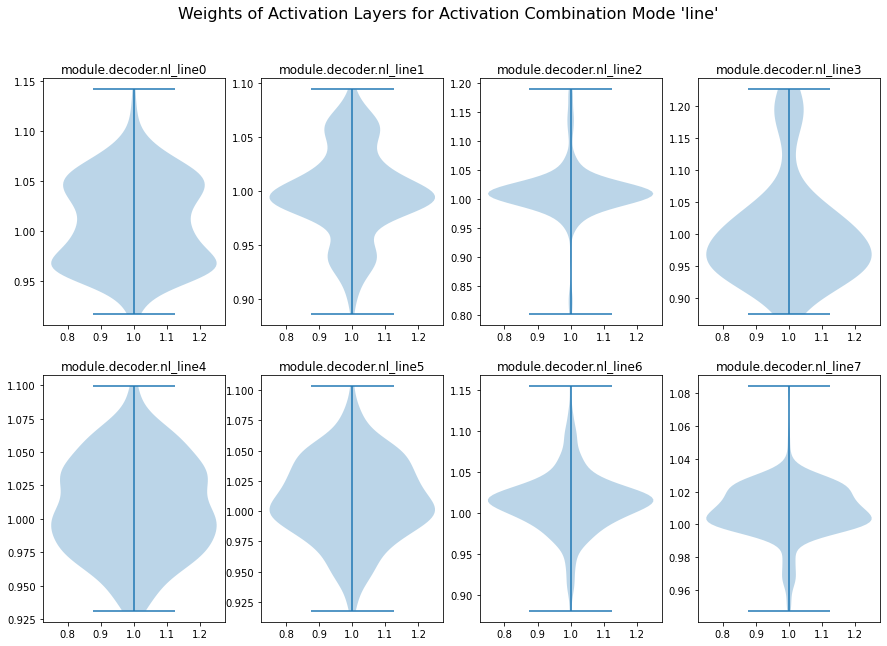

In [32]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/line/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'line'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_line" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

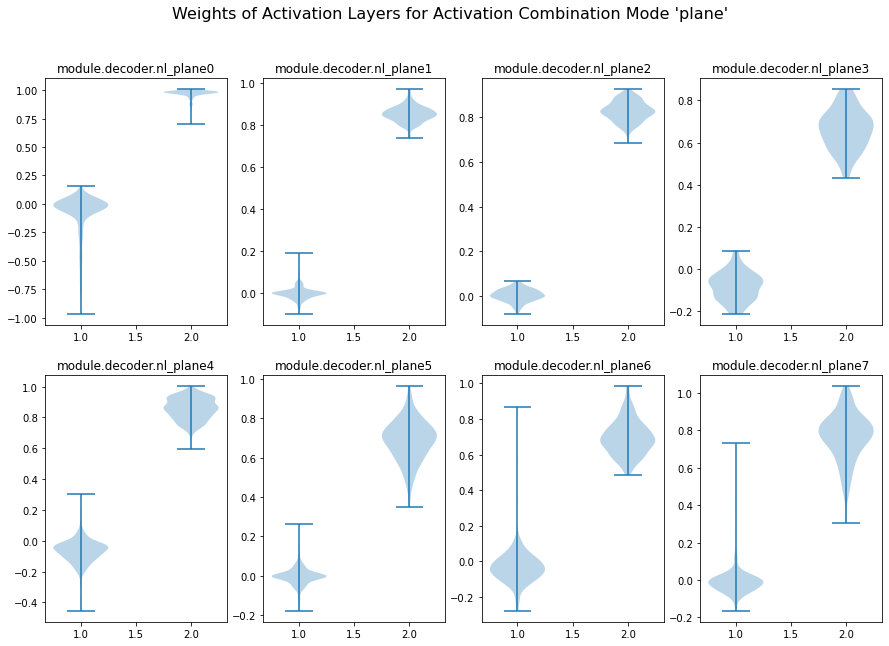

In [39]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/plane/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'plane'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_plane" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

In [4]:
import pandas as pd
data = pd.read_csv("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", delimiter=';')
print(f"{data['chamfer_dist'].mean():5f}, {data['chamfer_dist'].median():5f}")

0.083380, 0.083885


In [ ]:
python reconstruct.py  --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line --skip
python evaluate.py  --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line -c 2000

9

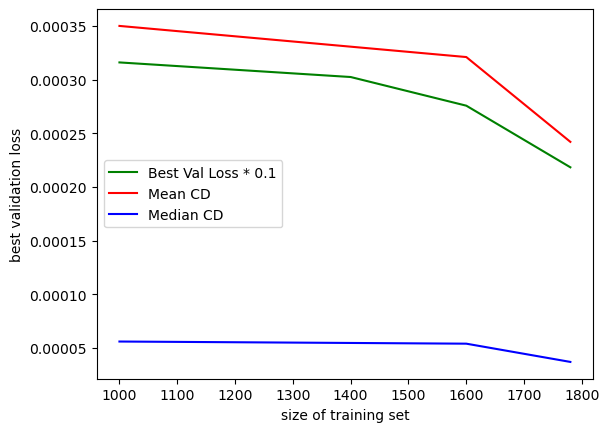

In [20]:
import numpy as np
from matplotlib import pyplot as plt
set_sizes = np.array([1780, 1600, 1400, 1200, 1000, 600, 200])
val_losses = np.array([2.183e-3, 2.757e-3, 3.024e-3, np.nan, 3.16e-3, np.nan, np.nan])
mean_CDs = np.array([0.242e-3, 0.321e-3, np.nan, np.nan, 0.350e-3, np.nan, np.nan])
median_CDs = np.array([0.037e-3, 0.054e-3, np.nan, np.nan, 0.056e-3, np.nan, np.nan])

plt.plot(set_sizes[np.isfinite(val_losses)], val_losses[np.isfinite(val_losses)]*0.1, 'g', label="Best Val Loss * 0.1")
plt.plot(set_sizes[np.isfinite(mean_CDs)], mean_CDs[np.isfinite(mean_CDs)], 'r', label="Mean CD")
plt.plot(set_sizes[np.isfinite(median_CDs)], median_CDs[np.isfinite(median_CDs)], 'b', label="Median CD")
plt.xlabel("size of training set")
plt.ylabel("best validation loss")
plt.legend()

In [21]:
import json
import random
import copy
import os
path = "/home/shared/deepsdfcomp/searches/splits/"
fname = "sv2_planes_train"
with open(os.path.join(path, fname + ".json"), 'r') as f:
    all_shapes_dict = json.load(f)
split_sizes = [1780, 1600, 1400, 1200, 1000, 800, 600, 400, 200]
for split_size in split_sizes:
    split = copy.deepcopy(all_shapes_dict)
    sampled_list = random.shuffle(split["ShapeNetV2"]["02691156"])
    split["ShapeNetV2"]["02691156"] = split["ShapeNetV2"]["02691156"][:split_size]
    with open(os.path.join(path, "subsamples", f"{fname} _{split_size}.json"), 'w+') as f:
        json.dump(split, f, indent=4)

"baseline"
	Curvature Sampling: 0 % 
	Mean CD: 1.467e-04
	Median CD: 4.003e-05
	Best Meshes:
		fdcb11fa39661f0fb08f81d66e854bfa with CD of 1.1679990103997374e-06
		df411aa240fe48d5855eb7906a7a7a04 with CD of 1.6090262747775775e-06
		d28a3cd771b2bf1e71d03b466c72ce41 with CD of 8.657810973807102e-06
	Worst Meshes:
		e3f562bd552fbb14496e2f80fb255499 with CD of 0.0101094990308915
		fc16704314dc71ee9a6e43b878d5b335 with CD of 0.00358775584537
		d8a037897d5d5b108130971b27e95927 with CD of 0.0029784317984686
"baseline"
	Curvature Sampling: 100 % 
	Mean CD: 1.569e-04
	Median CD: 4.239e-05
	Best Meshes:
		fdcb11fa39661f0fb08f81d66e854bfa with CD of 1.33504371448962e-06
		df411aa240fe48d5855eb7906a7a7a04 with CD of 1.867975110887468e-06
		e87902d01d40c71521b1ceea9c93aa79 with CD of 9.2522906176751e-06
	Worst Meshes:
		e3f562bd552fbb14496e2f80fb255499 with CD of 0.0107307604752931
		fc16704314dc71ee9a6e43b878d5b335 with CD of 0.0051297468956609
		d8a037897d5d5b108130971b27e95927 with CD of 0.0031

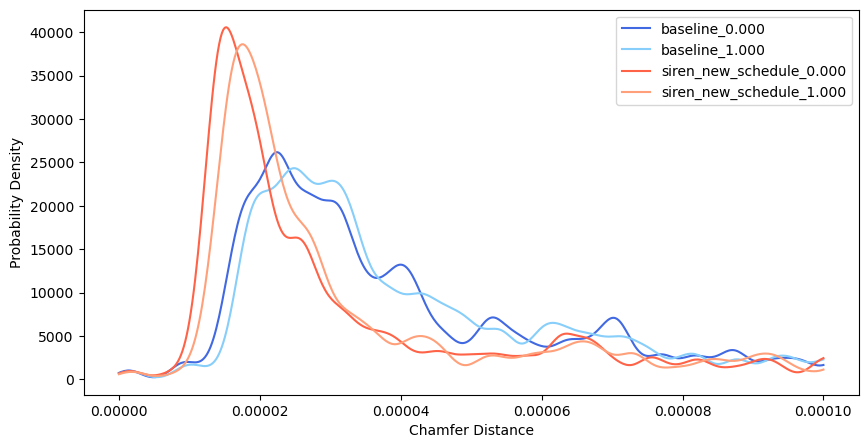

In [73]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
experiments = [
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer.csv", "royalblue"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.200.csv", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.300.csv", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_0.500.csv", "cyan"),
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Evaluation/2000/chamfer_1.000.csv", "lightskyblue"),
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer.csv", "tomato"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.200.csv", "cyan"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.300.csv", "cyan"), # best
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_0.500.csv", "cyan"), # best
                ("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_new_schedule/Evaluation/2000/chamfer_1.000.csv", "lightsalmon"), # best
                #( "/home/shared/deepsdfcomp/searches/num_shapes_search/all_shapes_batch_size_128/Evaluation/2000/chamfer.csv", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/line_5050_ini/Evaluation/2000/chamfer.csv", "cyan"),
                #( "/home/shared/deepsdfcomp/searches/double_nonlinearity/all_latentsize=200_width=256_lr=5e-4_int=150/Evaluation/2000/chamfer.csv", "cyan"),
            ]

plt.figure(figsize=(10,5))
for csv_path, color in experiments:
    CDs = pd.read_csv(csv_path, sep=";")
    # plt.hist(CDs, np.linspace(0, 0.002, 2000), alpha=1/len(csv_paths), label=csv_path.split("/")[-1])
    
    density = gaussian_kde(CDs["chamfer_dist"])
    density.covariance_factor = lambda : .003
    density._compute_covariance()
    x = np.linspace(0, 0.0001, 500)
    densities = density(x)
    
    # find best and worst meshes
    n = 3
    best_df= CDs.nsmallest(n, columns=["chamfer_dist"])
    worst_df= CDs.nlargest(n, columns=["chamfer_dist"])
    best_meshes = [mesh.split("/")[-1] for mesh in list(best_df["shape"])]
    best_mesh_cds = list(best_df["chamfer_dist"])
    worst_meshes = [mesh.split("/")[-1] for mesh in list(worst_df["shape"])]
    worst_mesh_cds = list(worst_df["chamfer_dist"])
    
    
    exp_name = csv_path.split("/Evaluation")[-2].split("/")[-1]
    curvature = "0.000" if "chamfer_" not in csv_path else csv_path.split("_")[-1].split(".csv")[0]
    plt.plot(x, densities, label=exp_name + "_" + curvature, color=color)
    print(f'"{exp_name}"')
    print(f"\tCurvature Sampling: {int(float(curvature) * 100)} % ")
    print(f"\tMean CD: {np.mean(CDs['chamfer_dist']):.3e}")
    print(f"\tMedian CD: {np.median(CDs['chamfer_dist']):.3e}")
    print(f"\tBest Meshes:")
    for bm, cd in zip(best_meshes, best_mesh_cds):
        print(f"\t\t{bm} with CD of {cd}")
    print(f"\tWorst Meshes:")
    for wm, cd in zip(worst_meshes, worst_mesh_cds):
        print(f"\t\t{wm} with CD of {cd}")
plt.legend()
_ = plt.xlabel("Chamfer Distance")
_ = plt.ylabel("Probability Density")


In [1]:
import trimesh
import os
import json
mesh_name = "d3b9114df1d8a3388e415c6cf89025f0"
mesh = trimesh.load(os.path.join("/mnt/hdd/ShapeNetCore.v2/02691156", mesh_name, "models/model_normalized.obj"))
with open(os.path.join("/mnt/hdd/ShapeNetCore.v2/02691156", mesh_name, "models/model_normalized.json"), 'r') as f:
    properties = json.load(f)
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(mesh.dump())
print(mesh.vertices.min(axis=0), mesh.vertices.max(axis=0))

surface_samples = trimesh.load(os.path.join("/home/shared/deepsdfcomp/data/SurfaceSamples/ShapeNetV2/02691156", mesh_name + ".ply"))
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(surface_samples.dump())
print(surface_samples.vertices.min(axis=0), surface_samples.vertices.max(axis=0))

reco = trimesh.load(os.path.join("/home/shared/deepsdfcomp/searches/double_nonlinearity/baseline/Reconstructions/2000/Meshes/ShapeNetV2/02691156", mesh_name + ".ply"))
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(reco.dump())
print(reco.vertices.min(axis=0), reco.vertices.max(axis=0))


# samples = np.load()
# samples = samples[samples.files[0]]
# print(samples.min(axis=0), samples.max(axis=0)) 

concatenating texture: may result in visual artifacts


[-0.285115 -0.075618 -0.36779 ] [0.285099 0.19598  0.40751 ]
[-0.285115   -0.0755929  -0.36055401] [0.285099   0.19592801 0.40506601]
[-0.68753284 -0.31896016 -0.7864542 ] [0.68319559 0.30436653 0.88733315]


'pos'